## Testing trained models on various images:
  * load in saved hats,glasses, and beard models 
  * test each model on the same single image and compare image results 
      * try on all pics, randomly select a one from data/pics
      * try how it works on noncropped images
         * require cropping to better recognize beard, glasses
         * hats require extra tuning (high false positive)
   
---
#### This cell is required in order to use GPU for running the model 

In [1]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import keras
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
                                    # (nothing gets printed in Jupyter, only if you run it standalone)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras
keras.backend.get_session().run(tf.global_variables_initializer())  

Using TensorFlow backend.


[facial recognizition software](https://github.com/ageitgey/face_recognition)

In [17]:
import face_recognition
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras_preprocessing.image import load_img, img_to_array
from keras.models import model_from_json
from keras.applications.vgg16 import preprocess_input
import os
from PIL import Image as pil_image

In [30]:
image = face_recognition.load_image_file("/Users/mindy/Desktop/Testing_Images/img2.jpg")
face_locations = face_recognition.face_locations(image)

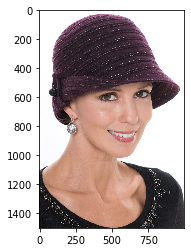

In [31]:
plt.imshow(image)
plt.show()

In [26]:
faces = cropping("/Users/mindy/Desktop/Testing_Images/img2.jpg")

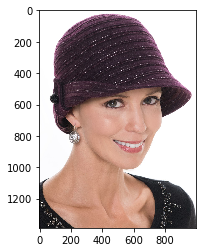

In [27]:
plt.imshow(faces[0])
plt.show()

In [18]:
def cropping(file_path):
    '''
    file_path: file_path for the image

    return cropped image of face
    '''
    # load image
    image = face_recognition.load_image_file(file_path)
    face_locations = face_recognition.face_locations(image)
    # list of images with tuples, 4 points
    # (ymin,xmax,ymax,xmin)
    faces = []
    for loc in face_locations:
        delta_y = loc[2] - loc[0]
        delta_x = loc[1] - loc[3]
        y_width = 2.5*delta_y  # experimented to find a good width for hats and beard
        x_increase = int((y_width - delta_x)/2)
        y_increase = int(1.5*delta_y/2)
        # make sure not to go out of range
        y_min = loc[0]-y_increase
        y_max = loc[2]+y_increase
        x_min = loc[3]-x_increase
        x_max = loc[1]+x_increase
        if x_min < 0:
            x_min = 0
        if x_max > image.shape[1]:
            x_max = image.shape[1]
        if y_min < 0:
            y_min = 0
        if y_max > image.shape[0]:
            y_max = image.shape[0]
        faces.append(image[y_min:y_max,x_min:x_max, :])
        return faces

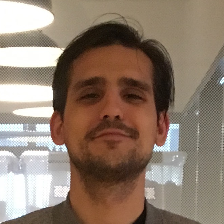

In [81]:
pil_image.fromarray(faces[0]).resize((224,224),pil_image.NEAREST)

In [74]:
faces[0].resize((224,224),pil_image.NEAREST)

TypeError: 'tuple' object cannot be interpreted as an integer

In [78]:
type(faces[0])

numpy.ndarray

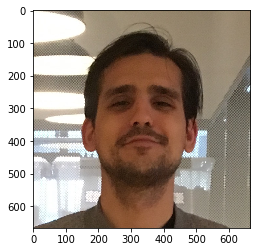

In [40]:
plt.imshow(faces[0])
plt.show()

In [47]:
# use 1.5 
y_width = 2.5*delta_y 
x_increase = int((y_width - delta_x)/2)

In [34]:
# test

In [29]:
test = face_locations  # 766:1033 is for shape[0], 1508:1776 is for shape[1], keep : 

delta_y = test[0][2]-test[0][0]
delta_x = test[0][1]-test[0][3]
h_y, h_x = delta_y/2, delta_x/2

In [24]:
center_y = (test[0][2]+test[0][0])/2
center_x = (test[0][1]+test[0][3])/2
center_y, center_x

(899.5, 1642.0)

---
#### Import necessary libraries

---
#### Import pretrained models: 

In [41]:
def load_pretrained_models(model_path,img_path):
    '''
    inputs:
    model_path: json model path for resnet50 or vgg16
    file_path2: path to saved best weights as h5 
    returns:
    saved models
    '''
    # load json and create model
    json_file = open('../tuning_data/vgg_16_model_224.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load model weight 
    loaded_model.load_weights(file_path)
    return loaded_model

#### Load all three models

In [44]:
# glasses_model =load_pretrained_models('../tuning_data/best_vgg_model_eyewears.h5')
# glasses_model_2 =load_pretrained_models('../tuning_data/best_vgg_model_eyewears_2.h5')
glasses_model_3 = load_pretrained_models('../tuning_data/untracked_too_big/best_vgg_model_eyewears_3.h5')

# hat_model = load_pretrained_models('../tuning_data/best_vgg_model_hat.h5')
hat_model_3 = load_pretrained_models('../tuning_data/untracked_too_big/best_vgg_model_hat_3.h5')

# beard_model = load_pretrained_models('../tuning_data/best_vgg_model_beard.h5')
# beard_model_2 = load_pretrained_models('../tuning_data/best_vgg_model_beard_2.h5')
beard_model_3 = load_pretrained_models('../tuning_data/untracked_too_big/best_vgg_model_beard_3.h5')

#### WARNINGS: in all three cases, 0 means yes and 1 means no 

### Checking images:

#### convert jpg image into np.array as data input

In [5]:
# os.listdir('/Users/mindy/Desktop/Testing_Images/')

In [77]:
img = load_img('/Users/mindy/Desktop/Testing_Images/img_1.jpg',target_size=(224,224))
# img = np.expand_dims(img,axis=0)
# img = preprocess_input(img)
# img = img/255
# imgs.
type(img)

PIL.Image.Image

In [82]:
def test_image_2(model,filepath,label):
    '''
    inputs:
    model: saved model
    filepath: path to file with images 
    label: a string, eyewear, hat, or beard
    returns:
    print an image plus labels
    '''
    files = os.listdir(filepath)
    for file in files:
        if file != '.DS_Store':
            faces = cropping(os.path.join(filepath,file))
            # img = load_img(os.path.join(filepath,file),target_size=(224,224))
            for face in faces:
                plt.imshow(face)
                plt.show()
                face = pil_image.fromarray(face).resize((224,224),pil_image.NEAREST)
                img = np.expand_dims(face,axis=0)
                img = preprocess_input(img)
                img = img/255
                if np.around(model.predict(img))[0]:  # 1 means no and 0 means yes
                    print(f'No {label}')
                else:
                    print(f'YES {label}')    

In [55]:
def test_image(model,filepath,label):
    '''
    inputs:
    model: saved model
    filepath: path to file with images 
    label: a string, eyewear, hat, or beard
    returns:
    print an image plus labels
    '''
    files = os.listdir(filepath)
    for file in files:
        if file != '.DS_Store':
            img = load_img(os.path.join(filepath,file),target_size=(224,224))
            plt.imshow(img)
            plt.show()
            img = np.expand_dims(img,axis=0)
            img = preprocess_input(img)
            img = img/255
            if np.around(model.predict(img))[0]:  # 1 means no and 0 means yes
                print(f'No {label}')
            else:
                print(f'YES {label}')    

In [5]:
def test_image_2(model,filepath,label):
    '''
    inputs:
    model: saved model
    filepath: path to file with images 
    label: a string, eyewear, hat, or beard
    returns:
    print an image plus labels
    '''
    files = os.listdir(filepath)
    total = len(files)
    correct = 0 
    for file in files:
        img = load_img(os.path.join(filepath,file),target_size=(150,150))
        img = img_to_array(img)/255
        img = np.expand_dims(img,axis=0)
        if not np.around(model.predict(img))[0]:  # 1 means no and 0 means yes
            correct += 1
    return correct/total

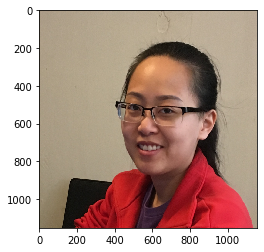

YES glasses


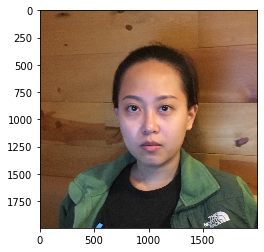

No glasses


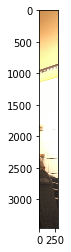

No glasses


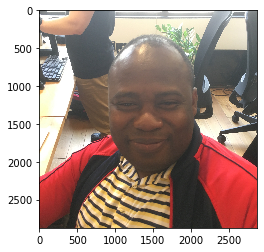

No glasses


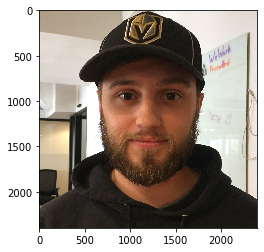

No glasses


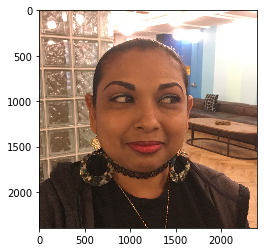

YES glasses


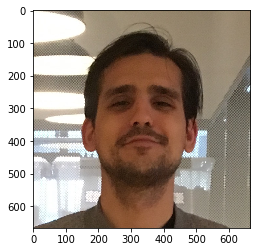

YES glasses


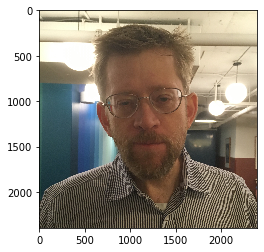

YES glasses


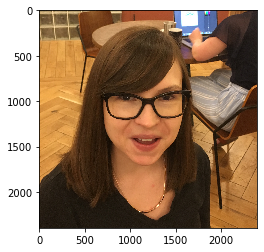

YES glasses


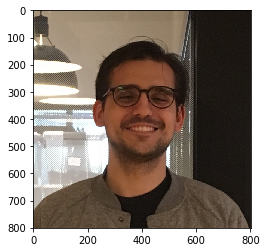

YES glasses


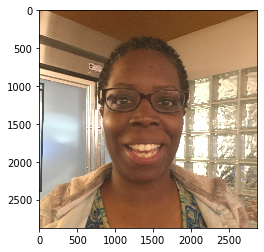

YES glasses


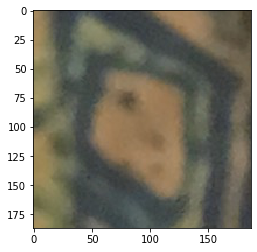

No glasses


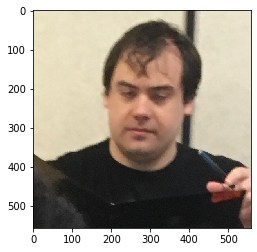

No glasses


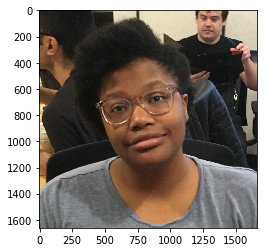

YES glasses


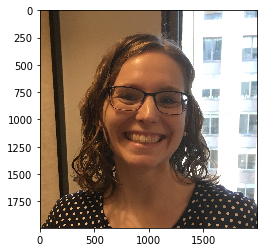

YES glasses


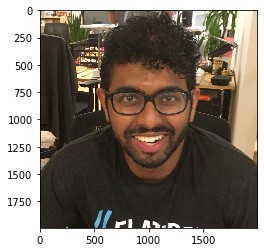

YES glasses


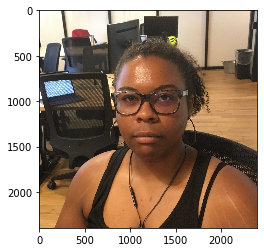

YES glasses


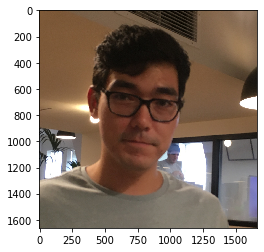

YES glasses


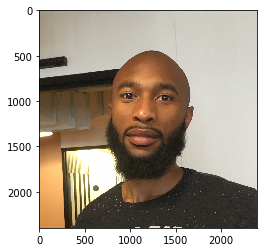

No glasses


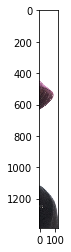

No glasses


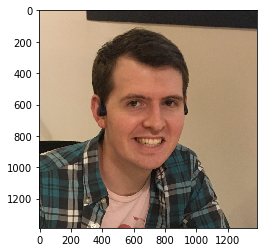

YES glasses


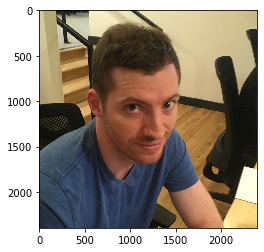

No glasses


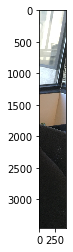

No glasses


ValueError: zero-size array to reduction operation minimum which has no identity

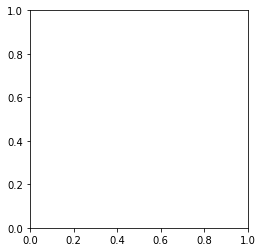

In [83]:
test_image_2(glasses_model_3,'/Users/mindy/Desktop/Testing_Images/','glasses')

### Randomly test on eyewear model 

In [16]:
# test_image(glasses_model_2, '../data/pics', 'eyewear')

### Test on cropped images 

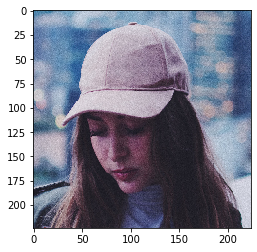

YES hat


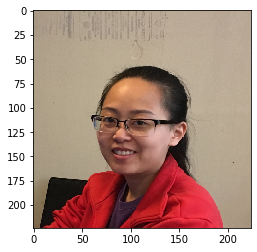

No hat


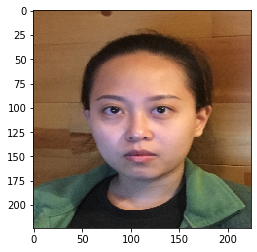

No hat


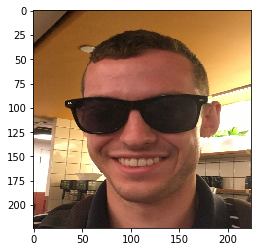

No hat


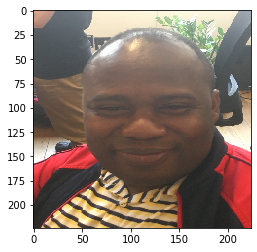

YES hat


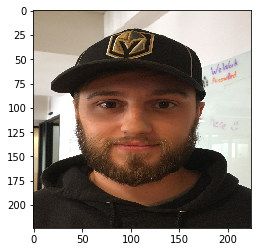

YES hat


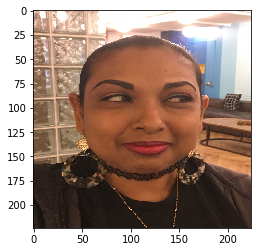

No hat


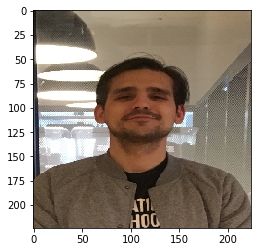

No hat


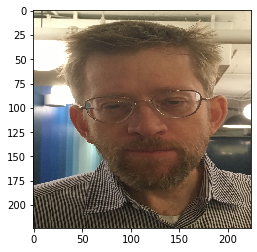

No hat


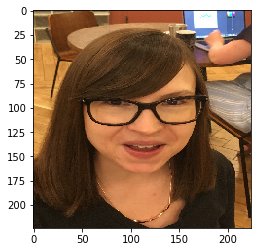

YES hat


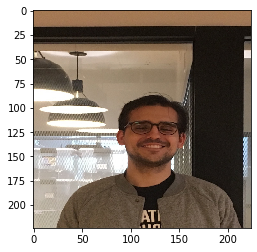

YES hat


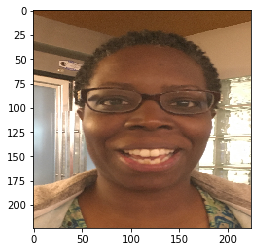

No hat


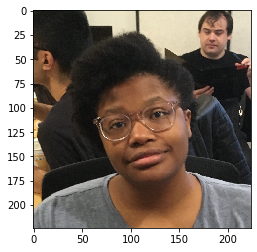

No hat


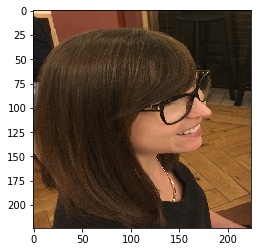

No hat


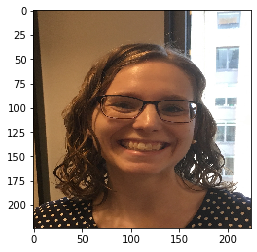

No hat


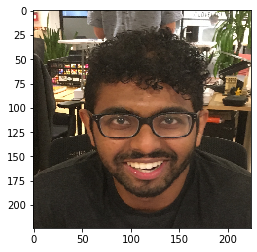

No hat


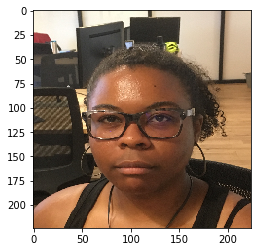

YES hat


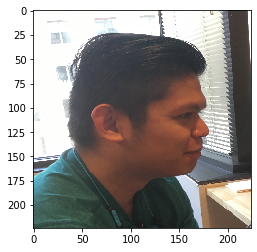

YES hat


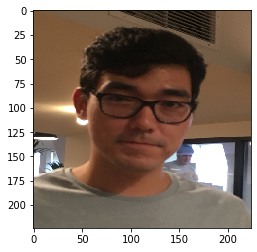

No hat


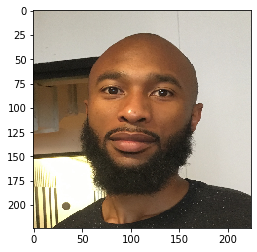

No hat


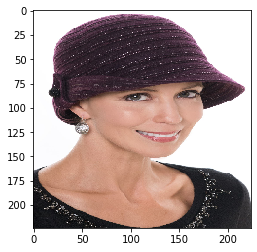

YES hat


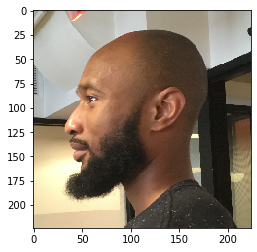

YES hat


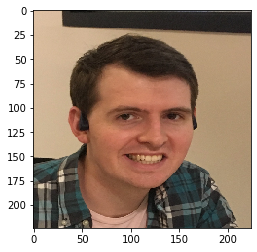

No hat


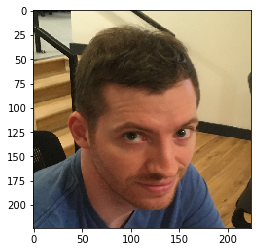

No hat


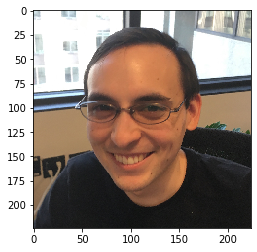

No hat


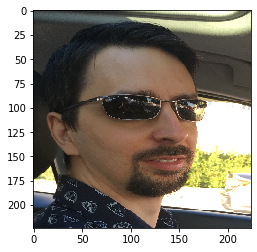

No hat


In [50]:
test_image(hat_model_3, '/Users/mindy/Desktop/Testing_Images_Cropped/','hat')

### Test on noncropped images 

In [10]:
# test_image(glasses_model_2, '/Users/mindy/Desktop/Testing_Images/','glasses')

In [6]:
# test_image_2(glasses_model, '/Datastore/GoogleImages/selected/sunglasses/','eyewear')

# needs thick ridges to pick up glasses, need to separate glasses from sunglasses 

0.7587412587412588

In [7]:
# test_image_2(glasses_model_3, '/Datastore/GoogleImages/selected/glasses/','eyewear')

0.73992673992674

In [7]:
# test_image_2(glasses_model_2, '/Datastore/GoogleImages/selected/sunglasses/','eyewear')

0.8986013986013986

In [8]:
# test_image_2(glasses_model_2, '/Datastore/GoogleImages/selected/glasses/','eyewear')

0.8424908424908425

### Randomly test on beard model 

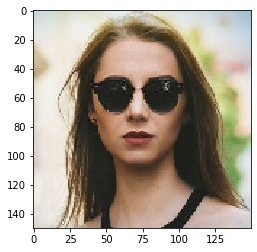

No beard


In [25]:
test_image(beard_model, '../data/pics', 'beard')

### Test on noncropped images 

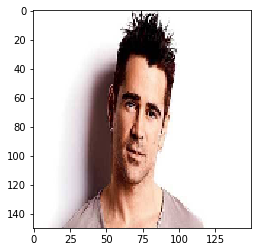

No beard


In [52]:
test_image(beard_model, '../data/zoom_out/','beard')

### Randomly test on hat model 

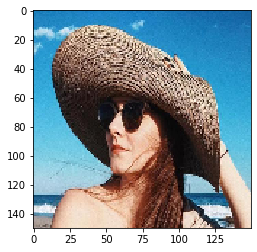

YES hat


In [61]:
test_image(hat_model, '../data/pics', 'hat')

In [11]:
test_image_2(beard_model_2, '/Datastore/GoogleImages/selected/beard/','beard')

0.5207667731629393

In [132]:
test_image_2(hat_model, '/Datastore/GoogleImages/selected/hat/','hat')

0.9137254901960784

### Test on noncropped images 

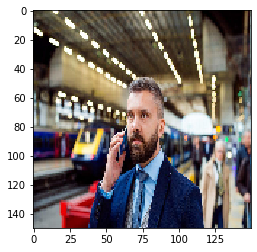

YES hat


In [68]:
test_image(hat_model, '../data/zoom_out/','hat')